# AlphaWave Data Corporate Supply Chain API: Bayesian Pairs Trading

**Kyle Horn, PhD.**<br>**Hugh Donnelly, CFA**<br> 
*AlphaWave Data*

**July 2020**

## 1. Introduction

Pairs trading is a classic approach to statistical arbitrage that has a long-standing track record. The traditional means of determining pairs trading has been through frequentist statistical cointegration tests, such as the Engle-Granger two-step test. 

Here we present a more sophisticated Bayesian approach to pairs trading using probabilistic programming, a form of Bayesian machine learning. Unlike simpler frequentist cointegration tests, our Bayesian approach allows us to monitor the relationship between a pair of equities over time, which allows us to follow pairs whose cointegration parameters change steadily or abruptly. When combined with a simple mean-reversion trading algorithm, we demonstrate this to be a viable theoretical trading strategy, ready for further evaluation and risk management.

One potential source for good pairs trading candidates is the corporate supply chain. Finding a company's actual suppliers and customers is often very difficult. Many companies do not want to reveal this information to their competitors. Leveraging hybrid data sources to deliver a complete picture of company supply chain ecosystems, the AlphaWave Data Corporate Supply Chain API enables investors to construct hedges and build statistical arbitrage strategies for a given corporate supply chain.

## 2. Methods

### 2.a Software

For this project, we use several Python-based scientific computing technologies using the Anaconda (https://www.anaconda.com/)  stack:
* JSON (https://json.org/) - Syntax for storing and exchanging data.
* Requests (https://requests.readthedocs.io/) - HTTP library for Python.
* Numpy (https://numpy.org/) - Scientific computing library for arrays & matrices.
* Pandas (https://pandas.pydata.org/) - Scientific computing library for data frames.
* Matplotlib (https://matplotlib.org/) & Seaborn (https://seaborn.pydata.org/) - Plotting packages.
* Jupyter Notebooks (https://jupyter.org/) - A web-based computational notebook environment.

In addition, we employ Bayesian machine learning through the following libraries:
* Theano (https://github.com/Theano/Theano) - A differentiable programming library, and competitor to TensorFlow.
* PyMC3 (https://docs.pymc.io/) - A Bayesian probabilistic programming package. Its simple syntax is excellent for prototyping.

We also make use of an equities backtesting engine and the AlphaWave Data Corporate Supply Chain API.

In [1]:
import json
import requests
import pymc3 as pm
import numpy as np
import pandas as pd
import theano as th
import seaborn as sns
import sklearn.decomposition
import matplotlib.pyplot as plt
%matplotlib notebook
sns.set()

import warnings
warnings.filterwarnings('ignore')

### 2.b Cointegration

Before we show how to use the AlphaWave Data Corporate Supply Chain API to select stocks for pairs trading, let's review cointegration.

When performing pairs trading, it is preferential if a portfolio of two stocks repeatedly _reverts_ to some fixed value. This consistent reversion lets us confidently short the portfolio when it is above this reversion value, and go long on the portfolio when it is below this value.

One mathematical approach codifying this notion of reverting to a fixed value is _cointegration_. Cointegration is effctively a stronger form of the more common statistical concept of _correlation_. When stocks are correlated, they tend to move similarly relative to one another (either in the same direction, or in opposition). Observe the two simulated stocks below, which demonstrate a high level of correlation:

In [2]:
normal_noise1 = np.random.randn(1000)
normal_noise2 = np.random.randn(1000)
simulated_stockA = (0.7*normal_noise1 + 0.5*normal_noise2).cumsum() + 20*np.random.randn(1)
simulated_stockB = (0.02*normal_noise1 + 0.75*normal_noise2).cumsum() + 20*np.random.randn(1)

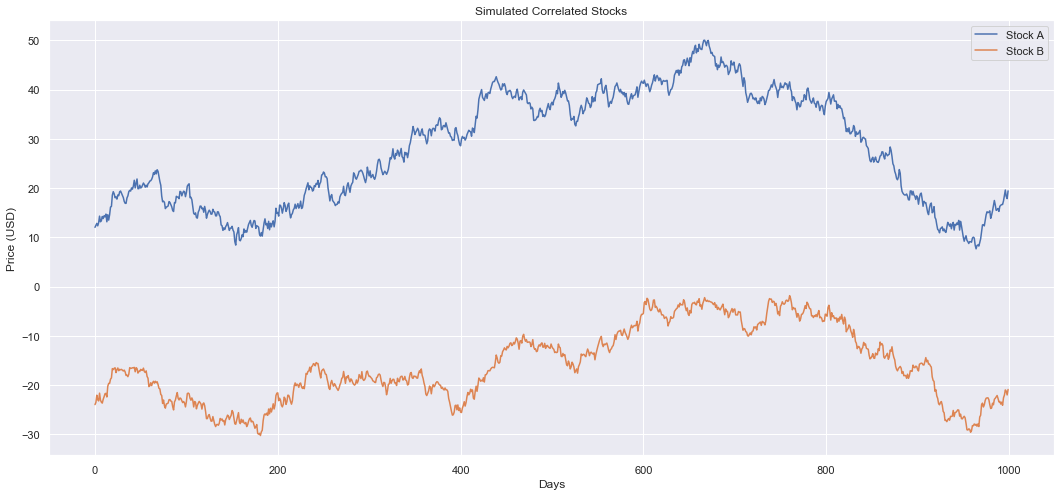

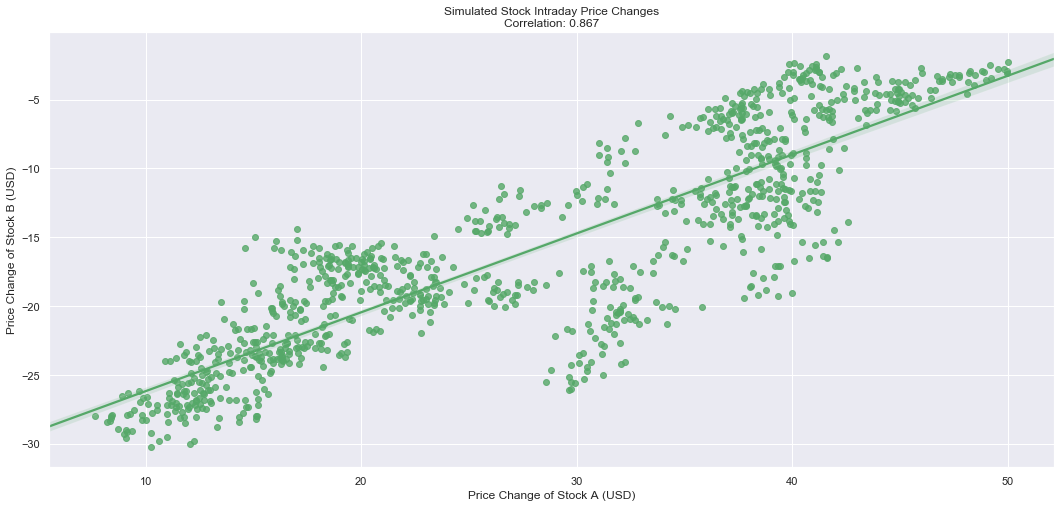

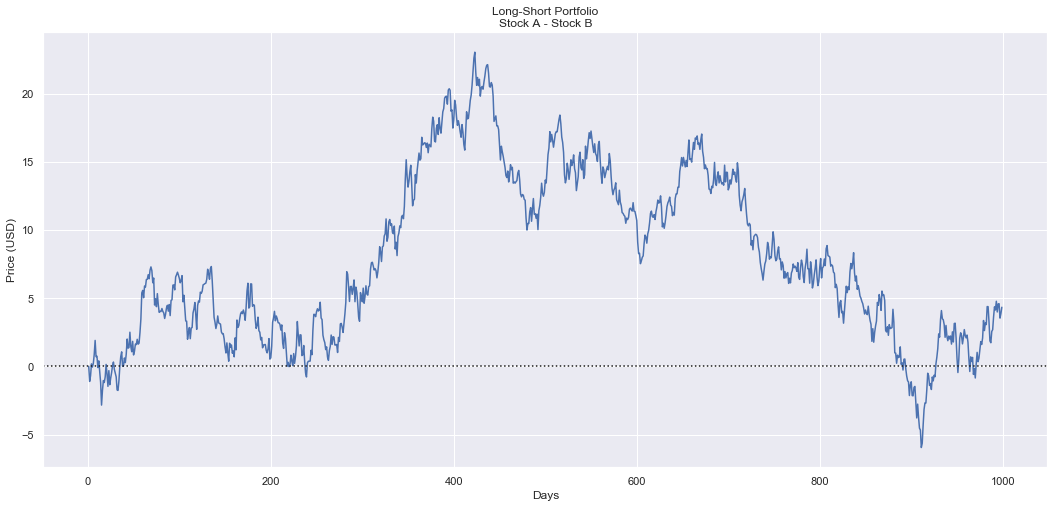

In [190]:
plt.figure(figsize = (18,8))
plt.title("Simulated Correlated Stocks")
plt.ylabel("Price (USD)")
plt.xlabel("Days")
plt.plot(simulated_stockA,label="Stock A")
plt.plot(simulated_stockB,label="Stock B")
plt.legend()

plt.figure(figsize = (18,8))
corr = np.corrcoef(simulated_stockA,simulated_stockB)[0][1]
plt.title(f"Simulated Stock Intraday Price Changes\nCorrelation: {round(corr,3)}")
plt.xlabel("Price Change of Stock A (USD)")
plt.ylabel("Price Change of Stock B (USD)")
sns.regplot(x=simulated_stockA,y=simulated_stockB,color=sns.color_palette()[2])

plt.figure(figsize = (18,8))
seriesA = pd.Series(simulated_stockA).diff().cumsum()
seriesB = pd.Series(simulated_stockB).diff().cumsum()
plt.title("Long-Short Portfolio\nStock A - Stock B")
plt.ylabel("Price (USD)")
plt.xlabel("Days")
plt.plot(seriesA-seriesB)
x0,xmax = plt.xlim()
plt.plot([x0,xmax],[0,0],'k:')
plt.xlim(x0,xmax)

plt.show()

As can be seen above, a portfolio of two highly correlated stocks have no guarantee of repeatedly crossing some fixed price without diverging. This is where cointegration deviates from correlation. When stocks are cointegrated, some linear combination of two stocks $A$ and $B$, with weightings $a$ and $b$, will produce a  portfolio $P$ with a lower _order of integration_ than either $A$ or $B$:

$$P = a A + b B$$

_Order of integration_ is defined as the number of times one must take the derivative of a signal to get a _stationary_ signal. When a signal is stationary, none of its statistical moments change over time. Most notably, the mean of the signal is therefore fixed, and any fluctuations in the stock must happen _around_ the mean. Aka, if the signal deviates from the mean, it _must_ revert back to the mean. This is precisely the behavior we want. Notice what happens when we take the derivative of stock A. Since stock A's derivative is stationary, stock A must have an order of integration of 1:

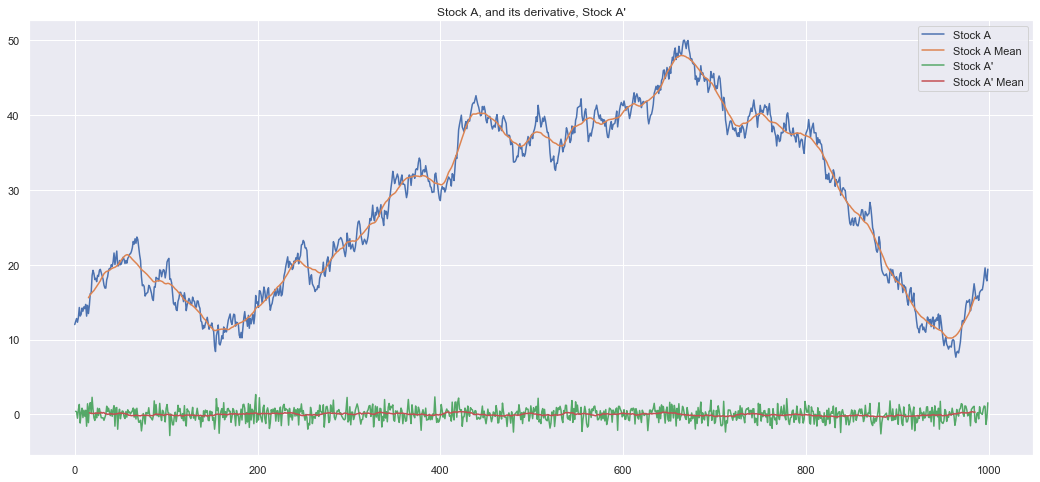

In [189]:
stockA_series = pd.Series(simulated_stockA)
plt.figure(figsize = (18,8))
plt.title("Stock A, and its derivative, Stock A'")
plt.plot(stockA_series)
plt.plot(stockA_series.rolling(30,center=True).mean())
plt.plot(stockA_series.diff())
plt.plot(stockA_series.diff().rolling(30,center=True).mean())
plt.legend(["Stock A","Stock A Mean","Stock A'","Stock A' Mean"])
plt.show()

Our simulated stocks happen to have an order of integration of 1 by design (because we are modeling them as Brownian motion, which will be discussed later), so if $A$ and $B$ are cointegrated, there must be some set of weights $a$ and $b$ that produces a $P$ with an order of integration of <1. If we assume all stocks can be modeled by Brownian motion, then we expect $P$ to have an order of integration of zero, and ergo be stationary.

When we generate two new simulated stocks: B and C, but this time ensure they are cointegrated based on the above definition, we can now get a portfolio that will cross some fixed line repeatedly and indefinitely:

In [5]:
c,d = 1.5,-.8
random_noise3 = np.random.randn(1000)
random_noise4 = np.random.randn(1000)
brownian_noise1 = 1.2*np.random.randn(1000).cumsum()
brownian_noise2 = np.random.randn(1000).cumsum()
simulated_stockC = (1./c)*brownian_noise1 + .8*random_noise3 + 20*np.random.randn()
simulated_stockD = (-1./d)*brownian_noise1 + 3.2*random_noise4 + 15*np.random.randn()

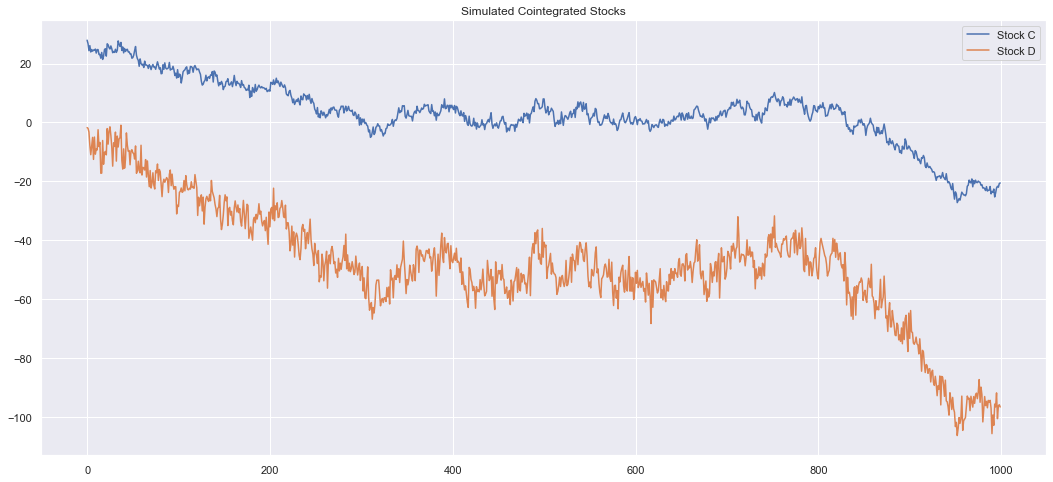

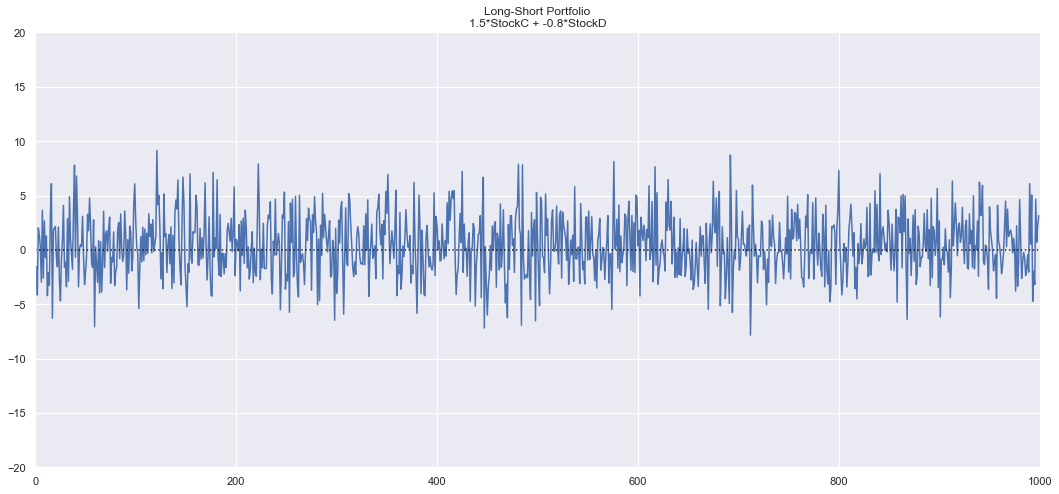

In [188]:
plt.figure(figsize = (18,8))
plt.title("Simulated Cointegrated Stocks")
plt.plot(simulated_stockC,label="Stock C")
plt.plot(simulated_stockD,label="Stock D")
plt.legend()

plt.figure(figsize = (18,8))
plt.title(f"Long-Short Portfolio\n{c}*StockC + {d}*StockD")
plt.plot(c*pd.Series(simulated_stockC).diff().cumsum()+d*pd.Series(simulated_stockD).diff().cumsum())
plt.ylim(-20,20)
plt.plot([0,1000],[0,0],'k:')
plt.xlim(0,1000)

plt.show()

Subsequently, this guarantee of mean-reversion is why pairs trading algorithms prefer cointegrated socks over simple correlated stocks.

### 2.c Stock Selection for Pairs Trading

Since our goal is to build a pairs trading algorithm, one potential source of cointegrated stocks is the corporate supply chain. Using the AlphaWave Data Corporate Supply Chain API, we can get a list of suppliers and customers for a given stock symbol. To call this API with Python, you can choose one of the supported Python code snippets provided in the API console. Here is an example of how to invoke the API with Python Requests.

In [3]:
url = "https://corporate-supply-chain.p.rapidapi.com/api/v1/resources/supplychain"

querystring = {"ticker":"IBM"}

headers = {
    'x-rapidapi-host': "YOUR_X-RAPIDAPI-HOST_WILL_COPY_DIRECTLY_FROM_RAPIDAPI_PYTHON_CODE_SNIPPETS",
    'x-rapidapi-key': "YOUR_X-RAPIDAPI-KEY_WILL_COPY_DIRECTLY_FROM_RAPIDAPI_PYTHON_CODE_SNIPPETS"
    }

response = requests.request("GET", url, headers=headers, params=querystring)

print(response.text)


[{"Ticker":"CMPGF","Full Name":"Compass Group PLC","Relationship":"Suppliers"},{"Ticker":"HTHIF","Full Name":"Hitachi, Ltd.","Relationship":"Suppliers"},{"Ticker":"FJTSF","Full Name":"Fujitsu Limited","Relationship":"Suppliers"},{"Ticker":"CAJFF","Full Name":"Canon Inc.","Relationship":"Suppliers"},{"Ticker":"SKSBF","Full Name":"Skanska AB (publ)","Relationship":"Suppliers"},{"Ticker":"RICOF","Full Name":"Ricoh Company, Ltd.","Relationship":"Suppliers"},{"Ticker":"SDXOF","Full Name":"Sodexo S.A.","Relationship":"Suppliers"},{"Ticker":"SSNLF","Full Name":"Samsung Electronics Co., Ltd.","Relationship":"Suppliers"},{"Ticker":"6701.T","Full Name":"NEC Corporation","Relationship":"Suppliers"},{"Ticker":"WPPGF","Full Name":"WPP plc","Relationship":"Suppliers"},{"Ticker":"VLKPF","Full Name":"Volkswagen AG","Relationship":"Customers"},{"Ticker":"PEUGF","Full Name":"Peugeot S.A.","Relationship":"Customers"},{"Ticker":"ABC","Full Name":"AmerisourceBergen Corporation","Relationship":"Customers"},

In [4]:
# Create DataFrame.  
df = pd.DataFrame.from_dict(response.json())
df

,Ticker,Full Name,Relationship
0,CMPGF,Compass Group PLC,Suppliers
1,HTHIF,"Hitachi, Ltd.",Suppliers
2,FJTSF,Fujitsu Limited,Suppliers
3,CAJFF,Canon Inc.,Suppliers
4,SKSBF,Skanska AB (publ),Suppliers
5,RICOF,"Ricoh Company, Ltd.",Suppliers
6,SDXOF,Sodexo S.A.,Suppliers
7,SSNLF,"Samsung Electronics Co., Ltd.",Suppliers
8,6701.T,NEC Corporation,Suppliers
9,WPPGF,WPP plc,Suppliers


That’s it!

Now you have a list of suppliers and customers in a pandas DataFrame for a given stock symbol (IBM in this example). If you wish, you can further filter the list of suppliers and customers using fundamental data, technical indicators, or other sources of alternative data to get a list of good pairs trading candidates.

In this example, we will select IBM's customer ABC to continue our pairs trading analysis. If you would like to explore the supply chain of a stock symbol other than IBM, there is a list of additional stock symbols that have supply chain data available at the end of this notebook.

### 2.d Market Data

For this exploration, we have pulled in several years worth of daily close data from IEX Cloud (https://iexcloud.io/), a financial data vendor.

In [5]:
IEX_API_Key = 'YOUR_IEX_API_KEY_HERE'

tickers = [ 'IBM', 'ABC', ]

#Create an empty string called `ticker_string` that we'll add tickers and commas to
ticker_string = ''

#Loop through every element of `tickers` and add them and a comma to ticker_string
for ticker in tickers: 
    ticker_string += ticker 
    ticker_string += ',' 
    
#Drop the last comma from `ticker_string`
ticker_string = ticker_string[:-1]

#Create the endpoint and years strings
endpoints = 'chart'
years = '5'

#Interpolate the endpoint strings into the HTTP_request string
HTTP_request = f'https://cloud.iexapis.com/stable/stock/market/batch?symbols={ticker_string}&types={endpoints}&range={years}y&cache=true&token={IEX_API_Key}'

#Send the HTTP request to the IEX Cloud API and store the response in a pandas DataFrame
stock_data = pd.read_json(HTTP_request)

#Create an empty list that we will append pandas Series of stock price data into
series_list = []

#Loop through each of our tickers and parse a pandas Series of their closing prices over the last 5 years
for ticker in tickers: 
    series_list.append(pd.DataFrame(stock_data[ticker]['chart'])['close'])

#Add in a column of dates
series_list.append(pd.DataFrame(stock_data['IBM']['chart'])['date'])

#Copy the 'tickers' list from earlier in the script, and add a new element called 'Date'. 
#These elements will be the column names of our pandas DataFrame later on.
column_names = tickers.copy()
column_names.append('Date')

#Concatenate the pandas Series togehter into a single DataFrame
stock_data = pd.concat(series_list, axis=1)

#Name the columns of the DataFrame and set the 'Date' column as the index
stock_data.columns = column_names
stock_data.set_index('Date', inplace = True)

In [6]:
stock1_name, stock2_name = 'IBM','ABC'
orig_data = stock_data.loc['2018-01-01':,]
data = orig_data.diff().cumsum()
data1 = data[stock1_name].ffill().fillna(0).values
data2 = data[stock2_name].ffill().fillna(0).values

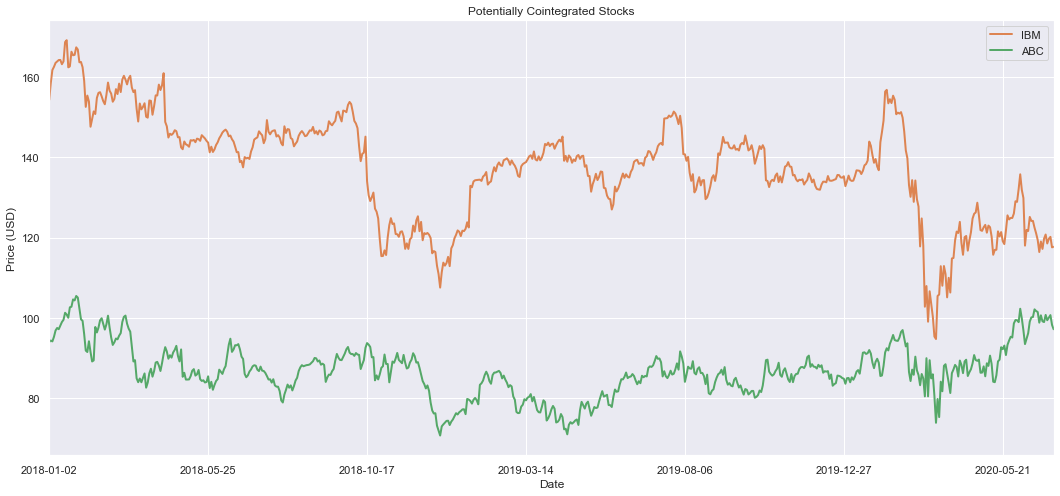

In [18]:
plt.figure(figsize = (18,8))
ax = plt.gca()
plt.title("Potentially Cointegrated Stocks")
orig_data[stock1_name].plot(ax=ax,color=sns.color_palette()[1],linewidth=2)
orig_data[stock2_name].plot(ax=ax,color=sns.color_palette()[2],linewidth=2)
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

### 2.e Bayesian Modeling

Our Bayesian model of stocks will not inherently make assumptions about the order of integration of the two stocks $S_1$ and $S_2$. But, as a simplifying assumption, we will assume that some linear combination of a cointegrated pair of stocks will, itself, be stationary, and Normally distributed, which we define here as the distribution $p$:

$$p = \alpha_1 S_1 + \alpha_2 S_2$$  
$$p \sim \mathcal{N}(\mu_p,\sigma^2_p)$$

Under classical frequentist definitions of cointegration, the two coefficients $\alpha_1$ and $\alpha_2$ are constants over all time. Subsequently, this can be a dangerous assumption to take, as stocks may go in and out of cointegration as internal business conditions or external market conditions change over time.

To address this, we propose a novel model of cointegration using probabilistic programming. Instead of assuming $\alpha_1$ and $\alpha_2$ are constants, we presume that at least one of them is a time-varying random variables, where the time step will be defined as subscript $t$. To further simplify the above equation for $p$, we assume $\alpha_2=1$ over all time, and rename $\alpha_1$ to the time varying variable $\beta_t$, to get the following final model for our cointegrated pairs:

$$p = \beta_t S_1 + S_2$$  
$$p \sim \mathcal{N}(\mu_p,\sigma^2_p)$$

For our $\beta_t$ to be a time varying random variable, we would prefer to choose a non-stationary distribution, so that it can move gradually over time. For this we choose Brownian motion, due to its simplicity of implementation, although it should be noted that the $\beta_t$ between two stocks could be a more complex stochastic time-series process, such as an autoregressive signal. Since we plan to model $\beta_t$ as Brownian noise, this gives it the following recursively-defined statistical distribution:

$$ \beta_t \sim \mathcal{N}(\beta_{t-1},\sigma^2_{\alpha}) $$

Finally, to help with convergence, we take one last simplifying assumption, and presume that $\mu_p=0$ and that $\sigma^2_p$ is sufficiently small that we can approximate $p$ to be simply zero. This leaves us with a highly simplified equation:

$$S_2 = - \beta_t S_1$$

When translated into PyMC3 syntax, we get the following model description:

In [9]:
with pm.Model() as model:
    
    # inject external stock data
    stock1 = th.shared(data1)
    stock2 = th.shared(data2)
    
    # define our cointegration variables
    beta_sigma = pm.Exponential('beta_sigma', 50.)
    beta = pm.GaussianRandomWalk('beta', sd=beta_sigma,
                                 shape=data1.shape[0])
    
    # with our assumptions, cointegration can be reframed as a regression problem
    stock2_regression = beta * stock1

    # Assume prices are Normally distributed, the mean comes from the regression.
    sd = pm.HalfNormal('sd', sd=.1)
    likelihood = pm.Normal('y',
                           mu=stock2_regression,
                           sd=sd,
                           observed=stock2)

In [10]:
with model:
    stock1.set_value(data1)
    stock2.set_value(data2)
    trace = pm.sample(2000,tune=1000,cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, beta, beta_sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 41 seconds.
The acceptance probability does not match the target. It is 0.8877919079475439, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


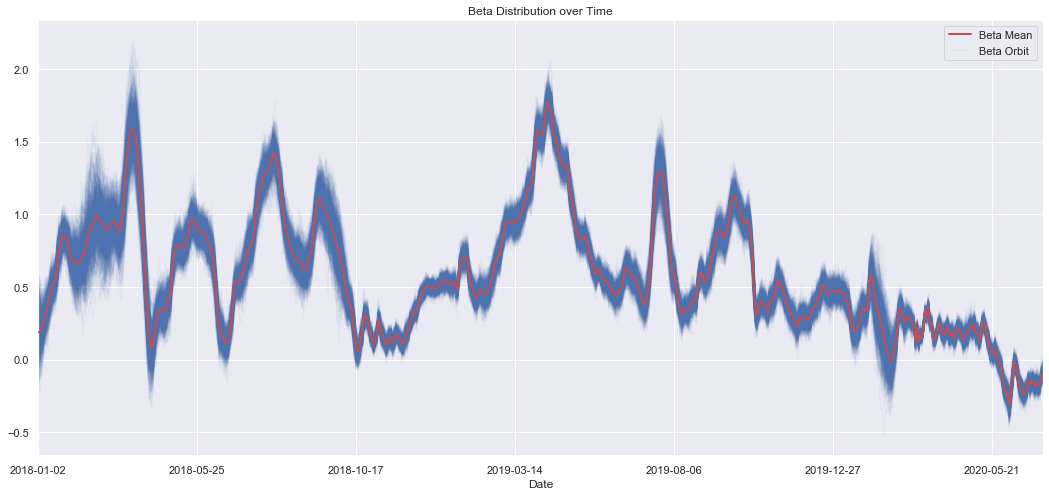

In [12]:
rolling_beta = trace[beta].T.mean(axis=1)

plt.figure(figsize = (18,8))
ax = plt.gca()
plt.title("Beta Distribution over Time")
pd.Series(rolling_beta,index=orig_data.index).plot(ax=ax,color='r',zorder=1e6,linewidth=2)
for orbit in trace[beta][:500]:
    pd.Series(orbit,index=orig_data.index).plot(ax=ax,color=sns.color_palette()[0],alpha=0.05)
plt.legend(['Beta Mean','Beta Orbit'])
#plt.savefig("beta distrib.png")

plt.show()

Notice that $\beta$ appears to shift between somewhat fixed regimes, and often does so abruptly.

### 2.f Trading Strategy

Knowing that two stocks may or may not be cointegrated does not explicitly define a trading strategy. For that we present the following simple mean-reversion style trading algorithm, which capitalizes on the assumed mean-reverting behavior of a cointegrated portfolio of stocks. We trade whenever our portfolio is moving back toward its mean value. When the algorithm is not trading, we dynamically update $\beta$ and its other parameters, to adapt to potentially changing cointegration conditions. Once a trade begins, we are forced to trade the two stocks at a fixed rate, and so our $\beta$ becomes locked for the duration of the trade. The algorithm's exact implementation is as follows:

1. Define a "signal", which should mean-revert to zero if $\beta$ remains relatively stationary.
2. Define a "smoothed signal", a 15-day moving average of the "signal".
2. If we are not trading...
 * Update $\beta$ so that it does not remain fixed while we aren't trading.
 * If the smoothed signal is above zero _and_ moving downward, short our portfolio.
 * If the smoothed signal is below zero _and_ moving upward, go long on our portfolio.
3. If we are trading long...
 * If the smoothed signal goes below its start value, close the trade; we may be diverging from the mean.
 * If the smoothed signal rises through the zero line, we've reached the mean. Close the trade.
4. If we are trading short...
 * If the smoothed signal goes above its start value, close the trade; we may be diverging from the mean.
 * If the smoothed signal falls through the zero line, we've reached the mean. Close the trade.

In [13]:
def getStrategyPortfolioWeights(rolling_beta,stock_name1,stock_name2,data,smoothing_window=15):

    data1 = data[stock_name1].ffill().fillna(0).values
    data2 = data[stock_name2].ffill().fillna(0).values

    # initial signal rebalance
    fixed_beta = rolling_beta[smoothing_window]
    signal = fixed_beta*data1 - data2
    smoothed_signal = pd.Series(signal).rolling(smoothing_window).mean()
    d_smoothed_signal = smoothed_signal.diff()
    trading = "not"
    trading_start = 0

    leverage = 0*data.copy()
    for i in range(smoothing_window,data1.shape[0]):
        leverage.iloc[i,:] = leverage.iloc[i-1,:]

        if trading=="not":

            # dynamically rebalance the signal when not trading
            fixed_beta = rolling_beta[i]
            signal = fixed_beta*data1 - data2
            smoothed_signal = pd.Series(signal).rolling(smoothing_window).mean()
            d_smoothed_signal = smoothed_signal.diff()

            if smoothed_signal[i]>0 and d_smoothed_signal[i]<0:

                leverage.iloc[i,0] = -fixed_beta / (abs(fixed_beta)+1)
                leverage.iloc[i,1] = 1 / (abs(fixed_beta)+1)

                trading = "short"
                trading_start = smoothed_signal[i]

            elif smoothed_signal[i]<0 and d_smoothed_signal[i]>0:

                fixed_beta = rolling_beta[i]
                leverage.iloc[i,0] = fixed_beta / (abs(fixed_beta)+1)
                leverage.iloc[i,1] = -1 / (abs(fixed_beta)+1)

                trading = "long"
                trading_start = smoothed_signal[i]

            else:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0


        elif trading=="long":

            # a failed trade
            if smoothed_signal[i] < trading_start:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"

            # a successful trade
            if smoothed_signal[i]>0:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"

        elif trading=="short":

            # a failed trade
            if smoothed_signal[i] > trading_start:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"

            # a successful trade
            if smoothed_signal[i]<0:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"
                
    return leverage

## 3. Results

### 3.a Backtesting & Performance in Market Drops

As a long-short algorithm, the expectation is that this algorithm would perform strongly during market drops. The backtest here includes the end-of-2018 market drop, the subsequent smaller drops early in 2019, and the coronavirus sell-off in March 2020.

In [14]:
portfolioWeights = getStrategyPortfolioWeights(rolling_beta,stock1_name, stock2_name,data).fillna(0)

In [15]:
def backtest(pricingDF,leverageDF,start_cash):
    """Backtests pricing based on some given set of leverage. Leverage works such that it happens "overnight",
    so leverage for "today" is applied to yesterday's close price. This algo can handle NaNs in pricing data
    before a stock exists, but ffill() should be used for NaNs that occur after the stock has existed, even
    if that stock ceases to exist later."""
    
    pricing = pricingDF.values
    leverage = leverageDF.values
    
    shares = np.zeros_like(pricing)
    cash = np.zeros(pricing.shape[0])
    cash[0] = start_cash
    curr_price = np.zeros(pricing.shape[1])
    curr_price_div = np.zeros(pricing.shape[1])
    
    for t in range(1,pricing.shape[0]):
        
        if np.any(leverage[t]!=leverage[t-1]):

            # handle non-existent stock values
            curr_price[:] = pricing[t-1]     # you can multiply with this one
            curr_price[np.isnan(curr_price)] = 0
            trading_allowed = (curr_price!=0)
            curr_price_div[:] = curr_price    # you can divide with this one
            curr_price_div[~trading_allowed] = 1
            
            # determine new positions (warning: leverage to non-trading_allowed stocks is just lost)
            portfolio_value = (shares[t-1]*curr_price).sum()+cash[t-1]
            target_shares = trading_allowed * (portfolio_value*leverage[t]) // curr_price_div
            
            # rebalance
            shares[t] = target_shares
            cash[t] = cash[t-1] - ((shares[t]-shares[t-1])*curr_price).sum()
            
        else:
            
            # maintain positions
            shares[t] = shares[t-1]
            cash[t] = cash[t-1]
    
    returns = (shares*np.nan_to_num(pricing)).sum(axis=1)+cash
    pct_returns = (returns-start_cash)/start_cash
    return (
        pd.DataFrame( shares, index=pricingDF.index, columns=pricingDF.columns ),
        pd.Series( cash, index=pricingDF.index ),
        pd.Series( pct_returns, index=pricingDF.index)
    )

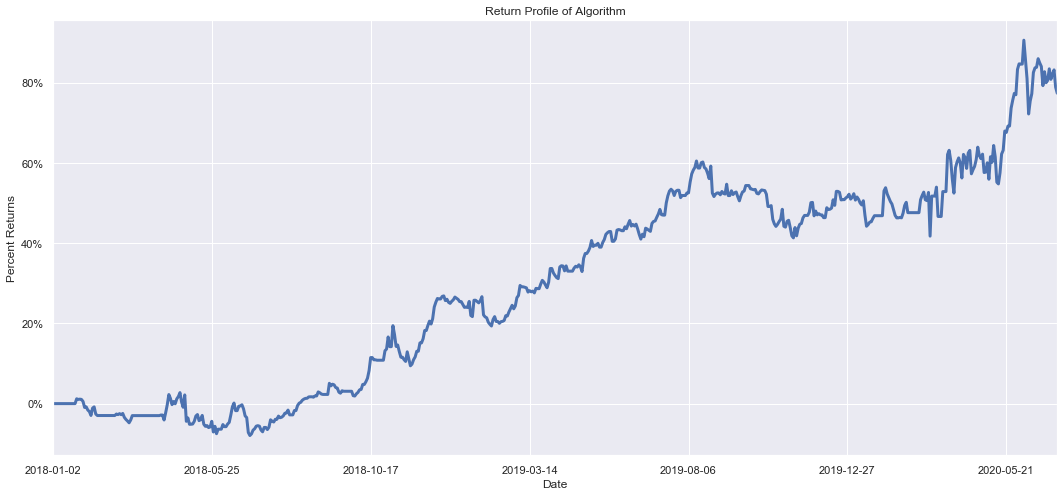

In [17]:
shares, cash, returns = backtest( orig_data, portfolioWeights, 1e6 )

plt.figure(figsize = (18,8))
ax = plt.gca()
plt.title("Return Profile of Algorithm")
plt.ylabel("Percent Returns")
returns.plot(ax=ax,linewidth=3)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
plt.show()

As we might have hoped, performance through market drops is strong. Returns are somewhat outsized due to our portfolio only being two stocks. For a finalized version of this algorithm, we might trade a hundred pairs or more to reduce volatility.

## 4. Conclusions & Potential Future Directions

Using the AlphaWave Data Corporate Supply Chain API to identify stock pairs, we demonstrated a robust prototype for what would be built into a more sophisticated pairs trading algorithm. There are many places where this algorithm and approach could be improved, including expanding the portfolio, creating criteria for when $\beta$ is suitable to trade over, backtesting over more periods, using a Bayesian model with fewer simplifying assumptions, and investigating potential nonlinear relationships between stocks. Each of these will be covered in the remainder of this section.

### 4.a Filtering Beta to Discard "Bad" Pairs

Through this paper we've mainly used $\beta$ to trade over a pair of stocks, regardless of the $\beta$'s behavior. Restricting trading to only happen when $\beta$ is stable might help identify stocks ideal for pairs trading, as it would be unreasonable to expect our algorithm would work flawlessly over every possible stock pairing imaginable.

### 4.b Additional Backtesting

While the current backtests are promising, the algorithm as it stands has not been put through rigorous backtesting over a wide variety of pairs and time periods. Ideally, this work would be scaled up dramatically, and an analysis of its performance over a much broader range of stocks would be a step toward a version of the algorithm ready to trade in the market. 

A deeper analysis into which stocks are ideal for pairing could also come from calculating $\beta$ over every possible pair in a large universe, such as the stocks in the Russell 3000 Index. Whether or not such relationships are significant should follow from whether or not high performing stock pairs have some idiosyncratic market structure relationship (eg: corporate supply chain, same industry, similar product, etc.), to help avoid overfitting.

### 4.c Model Simplifying Assumptions

Throughout this investigation, it was assumed that $p$ would vary so little as to be insignificant to the analysis. One could imagine that if fluctuations in $p$ were significant, then this assumption would be erroneous. Additionally, it was assumed that $p$ was stationary. One could envision a situation where $p$ was not stationary, but was still mean-reverting, such that its mean value was _nearly_ stationary. Such a pair of stocks might not be ideal in our current analysis, but may look more orderly with a different statistical model for $p$.

Relaxing simplifying assumptions on $p$ might reveal additional stocks that we could successfully do pairs trading over, and so in the case where we cannot find enough pairs with ideal $\beta$ properties, this could be a fruitful future direction.

### 4.d Cointegrated Groupings

Unlike standard frequentist cointegration testing, our Bayesian model is easily extensible to three or more stocks with little change in our model:

$$p = \beta_1 S_1 + \beta_2 S_2 + \beta_3 S_3 + ... + \beta_{n-1} S_{n-1} + S_n$$

The main change is that we now have additional $\beta$ variables. While it's unclear what effect trying to trade over a larger cointegrated portfolio (three or higher) would be, it would be entirely feasible to construct using Bayesian statistics and probabilistic programming.

### 4.e Deep Bayesian Analysis

Up until now, the assumption has been that a _linear_ combination of stocks produces some stationary (or low order-of-integration) distribution $p$. It's possible that some stocks may instead have a non-linear relationship. Instead of presuming simple linear weighting, we could apply a Bayesian neural network to the stocks to capture non-linear relationships. If we switched from PyMC3 and Theano to Edgar and TensorFlow, this would become entirely feasible to construct.

### 4.f Additional Supply Chain Tickers

In [ ]:
supplyChain_tickers = ['A', 'AA', 'AAL', 'AAN', 'AAP', 'AAPL', 'AAWW', 'AAXN', 'ABBV', 'ABC', 'ABT', 'ACCO', 
                       'ACIA', 'ACLS', 'ACM', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADMA', 'ADNT', 'ADP', 'ADPT', 'ADS', 
                       'ADSK', 'ADT', 'ADTN', 'AEIS', 'AEO', 'AEP', 'AERI', 'AES', 'AGCO', 'AGIO', 'AGS', 'AIR', 
                       'AIT', 'AJRD', 'AKAM', 'AKBA', 'AKR', 'ALB', 'ALE', 'ALGN', 'ALKS', 'ALLE', 'ALNY', 'ALRM', 
                       'ALSN', 'ALTR', 'ALXN', 'AMAG', 'AMAT', 'AMBA', 'AMC', 'AMCX', 'AMD', 'AME', 'AMG', 'AMGN', 
                       'AMKR', 'AMN', 'AMP', 'AMPH', 'AMRS', 'AMRX', 'AMSC', 'AMT', 'AMTD', 'AMWD', 'AMZN', 'AN', 
                       'ANET', 'ANF', 'ANSS', 'AOS', 'AOSL', 'APA', 'APD', 'APH', 'APO', 'APPN', 'APTV', 'AR', 
                       'ARCH', 'ARLO', 'ARMK', 'ARNC', 'AROC', 'ARW', 'ASH', 'ASIX', 'ASPN', 'ASTE', 'ATEC', 'ATEN', 
                       'ATEX', 'ATGE', 'ATI', 'ATKR', 'ATNI', 'ATNX', 'ATRO', 'ATRS', 'ATSG', 'ATVI', 'AVA', 'AVGO', 
                       'AVID', 'AVLR', 'AVT', 'AVTR', 'AVY', 'AVYA', 'AWI', 'AXL', 'AXP', 'AXTA', 'AXTI', 'AYI', 
                       'AYX', 'AZO', 'AZPN', 'AZZ', 'BA', 'BAND', 'BAX', 'BBBY', 'BBX', 'BBY', 'BC', 'BCC', 'BCO', 
                       'BCOV', 'BDC', 'BDSI', 'BDX', 'BE', 'BEN', 'BERY', 'BFAM', 'BG', 'BGS', 'BHE', 'BIG', 'BIIB', 
                       'BIO', 'BKD', 'BKH', 'BKI', 'BKR', 'BL', 'BLBD', 'BLD', 'BLDR', 'BLFS', 'BLK', 'BLL', 'BLMN', 
                       'BLUE', 'BMCH', 'BMRN', 'BMY', 'BNFT', 'BOX', 'BR', 'BREW', 'BRID', 'BRKR', 'BRKS', 'BSX', 
                       'BTU', 'BV', 'BWA', 'BXP', 'BYND', 'CAG', 'CAH', 'CAKE', 'CAL', 'CAMP', 'CAR', 'CARS', 
                       'CASA', 'CAT', 'CBB', 'CBMG', 'CBRE', 'CBT', 'CC', 'CCF', 'CCI', 'CCK', 'CCL', 'CCMP', 
                       'CCOI', 'CCRN', 'CDAY', 'CDE', 'CDMO', 'CDNA', 'CDNS', 'CDW', 'CDXC', 'CE', 'CECE', 'CEIX', 
                       'CELH', 'CENX', 'CERN', 'CERS', 'CETV', 'CF', 'CFX', 'CG', 'CGNX', 'CHD', 'CHDN', 'CHEF', 
                       'CHH', 'CHRW', 'CHTR', 'CIEN', 'CIR', 'CL', 'CLDR', 'CLF', 'CLNE', 'CLR', 'CLX', 'CMBM', 
                       'CMCO', 'CMCSA', 'CME', 'CMI', 'CMPR', 'CMS', 'CMTL', 'CNK', 'CNMD', 'CNP', 'CNR', 'CNX', 
                       'COG', 'COHR', 'COHU', 'COKE', 'COLD', 'COLM', 'COMM', 'CONN', 'COO', 'COP', 'COR', 'CORE', 
                       'COST', 'COTY', 'COUP', 'CPB', 'CPK', 'CPRX', 'CPS', 'CR', 'CRC', 'CREE', 'CRI', 'CRL', 
                       'CRM', 'CROX', 'CRS', 'CRUS', 'CRWD', 'CSCO', 'CSGP', 'CSGS', 'CSII', 'CSL', 'CSOD', 'CSX', 
                       'CTB', 'CTL', 'CTLT', 'CTS', 'CTSH', 'CTVA', 'CTXS', 'CUB', 'CVGW', 'CVI', 'CVLT', 'CVS', 
                       'CVTI', 'CVX', 'CW', 'CWEN', 'CXO', 'CZR', 'D', 'DAL', 'DAN', 'DBD', 'DBI', 'DBX', 'DCI', 
                       'DD', 'DDD', 'DE', 'DECK', 'DELL', 'DENN', 'DFIN', 'DG', 'DGII', 'DGX', 'DHC', 'DHR', 'DHX', 
                       'DIN', 'DIOD', 'DIS', 'DISCA', 'DISCK', 'DISH', 'DKS', 'DLB', 'DLR', 'DLTR', 'DLX', 'DNKN', 
                       'DNOW', 'DOCU', 'DOMO', 'DOV', 'DOW', 'DPZ', 'DRI', 'DSPG', 'DSSI', 'DTE', 'DUK', 'DVAX', 
                       'DVN', 'DXC', 'DXCM', 'DXPE', 'DY', 'DZSI', 'EA', 'EAF', 'EAT', 'EBAY', 'EBIX', 'ECL', 
                       'ECOL', 'ECOM', 'ED', 'EE', 'EEFT', 'EFX', 'EGHT', 'EGOV', 'EIGI', 'EL', 'ELAN', 'ELF', 
                       'ELY', 'EME', 'EMN', 'EMR', 'ENDP', 'ENPH', 'ENR', 'ENS', 'ENV', 'EOG', 'EPAM', 'EPAY', 
                       'EPC', 'EQC', 'EQIX', 'ERI', 'ESI', 'ESRT', 'ESTC', 'ETN', 'ETR', 'ETRN', 'EVC', 'EVER', 
                       'EVOP', 'EVR', 'EVRI', 'EW', 'EXAS', 'EXC', 'EXEL', 'EXP', 'EXPE', 'EXTN', 'EXTR', 'EYE', 
                       'F', 'FANG', 'FB', 'FBHS', 'FBIO', 'FCPT', 'FCX', 'FDP', 'FDX', 'FE', 'FEYE', 'FFIV', 'FHI', 
                       'FICO', 'FIS', 'FISV', 'FIT', 'FIVN', 'FL', 'FLDM', 'FLIR', 'FLNT', 'FLO', 'FLR', 'FLS', 
                       'FLT', 'FLWS', 'FMC', 'FNKO', 'FOLD', 'FOSL', 'FOX', 'FOXA', 'FRPT', 'FRTA', 'FSCT', 'FSLR', 
                       'FSLY', 'FSS', 'FTNT', 'FTV', 'FUL', 'FWONA', 'FWONK', 'G', 'GAIA', 'GCI', 'GD', 'GDDY', 
                       'GDEN', 'GDOT', 'GE', 'GEF', 'GES', 'GFF', 'GGG', 'GH', 'GHC', 'GHL', 'GIII', 'GILD', 'GIS', 
                       'GLT', 'GLUU', 'GLW', 'GM', 'GME', 'GNE', 'GNMK', 'GNRC', 'GNTX', 'GOGO', 'GOLF', 'GOOG', 
                       'GOOGL', 'GPC', 'GPK', 'GPN', 'GPOR', 'GPRE', 'GPRO', 'GPS', 'GPX', 'GRA', 'GRMN', 'GRPN', 
                       'GRUB', 'GSB', 'GSIT', 'GSKY', 'GT', 'GTLS', 'GTN', 'GTT', 'GVA', 'GWRE', 'GWW', 'H', 'HA', 
                       'HAE', 'HAIN', 'HAL', 'HALO', 'HAS', 'HBB', 'HBI', 'HCA', 'HCC', 'HCHC', 'HCKT', 'HD', 'HDS', 
                       'HEAR', 'HEI', 'HELE', 'HFC', 'HHC', 'HII', 'HIW', 'HL', 'HLIT', 'HLT', 'HLX', 'HMHC', 
                       'HMTV', 'HNI', 'HOG', 'HOLX', 'HOME', 'HON', 'HP', 'HPE', 'HPQ', 'HRC', 'HRL', 'HSC', 'HSKA', 
                       'HSTM', 'HSY', 'HTLD', 'HTZ', 'HUBB', 'HUBS', 'HUN', 'HURC', 'HURN', 'HWM', 'HXL', 'HY', 
                       'HZNP', 'IAC', 'IART', 'IBM', 'ICAD', 'ICE', 'ICPT', 'ICUI', 'IDA', 'IDCC', 'IDT', 'IEX', 
                       'IFF', 'IHRT', 'III', 'IIN', 'IIVI', 'ILMN', 'ILPT', 'IMAX', 'IMMR', 'INCY', 'INFN', 'INGR', 
                       'INOV', 'INSG', 'INT', 'INTC', 'INTU', 'IONS', 'IP', 'IPAR', 'IPG', 'IPGP', 'IPHI', 'IQV', 
                       'IR', 'IRBT', 'IRDM', 'IRM', 'IRWD', 'ITI', 'ITRI', 'ITT', 'ITW', 'IVZ', 'J', 'JAZZ', 'JBL', 
                       'JBLU', 'JCI', 'JCOM', 'JEF', 'JELD', 'JKHY', 'JLL', 'JNJ', 'JNPR', 'JOE', 'JWN', 'K', 
                       'KALU', 'KAMN', 'KAR', 'KBR', 'KDMN', 'KDP', 'KELYA', 'KEX', 'KEYS', 'KHC', 'KLAC', 'KMB', 
                       'KMI', 'KMT', 'KN', 'KNX', 'KO', 'KOP', 'KOS', 'KR', 'KRO', 'KSS', 'KTB', 'KTOS', 'KVHI', 
                       'KWR', 'LANC', 'LB', 'LCI', 'LCUT', 'LE', 'LEA', 'LECO', 'LEG', 'LFUS', 'LGND', 'LH', 'LHX', 
                       'LII', 'LIND', 'LITE', 'LIVX', 'LLY', 'LM', 'LMNX', 'LMT', 'LNG', 'LNT', 'LNTH', 'LOGM', 
                       'LOW', 'LPG', 'LPSN', 'LPX', 'LQDA', 'LQDT', 'LRCX', 'LSCC', 'LTRPA', 'LUNA', 'LVGO', 'LVS', 
                       'LW', 'LXRX', 'LYB', 'LYFT', 'LYV', 'LZB', 'M', 'MAC', 'MAN', 'MANH', 'MAR', 'MAS', 'MASI', 
                       'MAT', 'MAXR', 'MBII', 'MBUU', 'MCD', 'MCFT', 'MCHP', 'MCK', 'MCO', 'MCS', 'MDB', 'MDLZ', 
                       'MDP', 'MDRX', 'MDT', 'MDU', 'MEC', 'MEET', 'MEIP', 'MESA', 'MGI', 'MGM', 'MHK', 'MIDD', 
                       'MIK', 'MIME', 'MKC', 'MKSI', 'MKTX', 'MLM', 'MMC', 'MMM', 'MMSI', 'MNK', 'MNKD', 'MNST', 
                       'MO', 'MOBL', 'MOD', 'MODN', 'MORN', 'MOS', 'MOV', 'MPC', 'MPWR', 'MR', 'MRC', 'MRCY', 'MRK', 
                       'MRO', 'MRTN', 'MRVL', 'MSA', 'MSFT', 'MSGN', 'MSGS', 'MSI', 'MSON', 'MSTR', 'MTCH', 'MTD', 
                       'MTDR', 'MTN', 'MTOR', 'MTRX', 'MTSC', 'MTSI', 'MTW', 'MTX', 'MTZ', 'MU', 'MUR', 'MWA', 
                       'MXIM', 'MXL', 'MYGN', 'MYL', 'NATH', 'NATI', 'NAV', 'NBEV', 'NBIX', 'NBL', 'NBR', 'NC', 
                       'NCLH', 'NCMI', 'NCR', 'NDAQ', 'NDSN', 'NEE', 'NEM', 'NEO', 'NEOG', 'NET', 'NEU', 'NEWR', 
                       'NEX', 'NFG', 'NFLX', 'NGVT', 'NI', 'NJR', 'NKE', 'NKTR', 'NLOK', 'NLS', 'NOC', 'NOV', 'NOW', 
                       'NP', 'NPO', 'NR', 'NRG', 'NSC', 'NSCO', 'NSIT', 'NSP', 'NSTG', 'NTAP', 'NTGR', 'NTNX', 
                       'NTRA', 'NTUS', 'NUAN', 'NUE', 'NVDA', 'NVTA', 'NWE', 'NWL', 'NWN', 'NWPX', 'NWS', 'NWSA', 
                       'NXST', 'NYT', 'OC', 'ODP', 'OGE', 'OGS', 'OI', 'OII', 'OKE', 'OKTA', 'OLED', 'OLN', 'OMC', 
                       'OMCL', 'OMER', 'OMF', 'OMI', 'ON', 'ONTO', 'OOMA', 'OPK', 'OPTN', 'ORA', 'ORBC', 'ORCL', 
                       'OSG', 'OSIS', 'OSK', 'OSMT', 'OSPN', 'OSTK', 'OSUR', 'OTTR', 'OUT', 'OXM', 'OXY', 'PANW', 
                       'PARR', 'PBH', 'PBI', 'PBYI', 'PCAR', 'PCG', 'PCRX', 'PDCE', 'PDFS', 'PDLI', 'PE', 'PEG', 
                       'PEGA', 'PENN', 'PEP', 'PETQ', 'PFE', 'PFGC', 'PFNX', 'PFSI', 'PFSW', 'PG', 'PGEN', 'PGNY', 
                       'PGTI', 'PH', 'PI', 'PII', 'PINC', 'PING', 'PINS', 'PK', 'PKE', 'PKG', 'PKI', 'PLAB', 'PLAN', 
                       'PLCE', 'PLD', 'PLT', 'PLUG', 'PLUS', 'PM', 'PNM', 'PNW', 'PODD', 'POL', 'POR', 'POST', 
                       'POWI', 'PPC', 'PPG', 'PPL', 'PRAH', 'PRFT', 'PRGO', 'PRGS', 'PRIM', 'PRMW', 'PRO', 'PRSP', 
                       'PS', 'PSN', 'PSNL', 'PSTG', 'PSX', 'PTC', 'PTCT', 'PTLA', 'PTON', 'PTSI', 'PUMP', 'PVAC', 
                       'PVH', 'PWR', 'PXD', 'PYPL', 'QADA', 'QCOM', 'QLYS', 'QRTEA', 'QRVO', 'QTNT', 'QTRX', 'QTWO', 
                       'QUAD', 'R', 'RAD', 'RAMP', 'RARE', 'RBBN', 'RBC', 'RCII', 'RCKY', 'RCL', 'RDUS', 'REGN', 
                       'REVG', 'REZI', 'RGCO', 'RGLD', 'RGNX', 'RGP', 'RGR', 'RIG', 'RL', 'RMBS', 'RMD', 'RMNI', 
                       'RNG', 'ROG', 'ROK', 'ROKU', 'ROP', 'RPD', 'RPM', 'RRC', 'RS', 'RSG', 'RST', 'RTIX', 'RTX', 
                       'RUSHA', 'RUSHB', 'RYN', 'SABR', 'SAFM', 'SAGE', 'SAIA', 'SAIC', 'SAIL', 'SAM', 'SANM', 
                       'SATS', 'SBAC', 'SBBP', 'SBGI', 'SBUX', 'SCHW', 'SCL', 'SCOR', 'SCS', 'SCSC', 'SCWX', 'SEE', 
                       'SEIC', 'SERV', 'SFIX', 'SGEN', 'SGH', 'SGMS', 'SHAK', 'SHEN', 'SHOO', 'SHW', 'SHYF', 'SIG', 
                       'SIRI', 'SITE', 'SIX', 'SJI', 'SJM', 'SKT', 'SKX', 'SKYW', 'SLAB', 'SLB', 'SLCA', 'SLGN', 
                       'SMAR', 'SMCI', 'SMG', 'SMP', 'SMPL', 'SMSI', 'SMTC', 'SNA', 'SNPS', 'SNX', 'SO', 'SON', 
                       'SONO', 'SPB', 'SPG', 'SPGI', 'SPLK', 'SPNE', 'SPOK', 'SPR', 'SPSC', 'SPTN', 'SPWH', 'SPWR', 
                       'SQ', 'SRCL', 'SRE', 'SREV', 'SRI', 'SRNE', 'SRPT', 'SSNC', 'SSP', 'SSTI', 'STLD', 'STMP', 
                       'STXS', 'STZ', 'SUPN', 'SVC', 'SVMK', 'SWBI', 'SWI', 'SWK', 'SWKS', 'SWM', 'SWN', 'SWX', 
                       'SXC', 'SXT', 'SYF', 'SYK', 'SYKE', 'SYNA', 'SYNH', 'SYY', 'T', 'TACO', 'TALO', 'TAP', 
                       'TAST', 'TBI', 'TCO', 'TDC', 'TDG', 'TDOC', 'TDW', 'TDY', 'TECH', 'TEN', 'TENB', 'TER', 
                       'TERP', 'TEX', 'TFX', 'TGI', 'TGNA', 'TGT', 'THC', 'THO', 'THRM', 'THS', 'TIF', 'TILE', 
                       'TJX', 'TKR', 'TMO', 'TMUS', 'TNAV', 'TNC', 'TNDM', 'TNET', 'TPCO', 'TPIC', 'TPR', 'TPX', 
                       'TREE', 'TREX', 'TRGP', 'TRIP', 'TRMB', 'TRN', 'TRNS', 'TRS', 'TRTN', 'TRU', 'TRWH', 'TSE', 
                       'TSLA', 'TSN', 'TT', 'TTC', 'TTD', 'TTEC', 'TTMI', 'TTWO', 'TUP', 'TVTY', 'TWLO', 'TWNK', 
                       'TWST', 'TWTR', 'TXMD', 'TXN', 'TXT', 'True', 'UA', 'UAA', 'UAL', 'UBER', 'UEIC', 'UFI', 
                       'UFPI', 'UFS', 'UHS', 'UHT', 'UI', 'UIS', 'UNF', 'UNFI', 'UNIT', 'UNP', 'UNVR', 'UPLD', 
                       'UPS', 'UPWK', 'URBN', 'USFD', 'USX', 'UTHR', 'UTI', 'UVV', 'V', 'VAC', 'VAR', 'VC', 'VCRA', 
                       'VCYT', 'VECO', 'VEEV', 'VFC', 'VG', 'VIAC', 'VIACA', 'VIAV', 'VICR', 'VIVO', 'VLO', 'VMW', 
                       'VNDA', 'VNO', 'VPG', 'VRA', 'VRAY', 'VREX', 'VRNT', 'VRRM', 'VRS', 'VRSN', 'VRTV', 'VRTX', 
                       'VSAT', 'VSH', 'VSTM', 'VSTO', 'VTOL', 'VTR', 'VVV', 'VZ', 'W', 'WAB', 'WAT', 'WBA', 'WBT', 
                       'WCC', 'WDAY', 'WDC', 'WEC', 'WELL', 'WEN', 'WEX', 'WGO', 'WH', 'WHR', 'WIFI', 'WING', 'WK', 
                       'WKHS', 'WLDN', 'WLK', 'WLL', 'WM', 'WMB', 'WMS', 'WMT', 'WNC', 'WOR', 'WORK', 'WPX', 'WRK', 
                       'WSM', 'WST', 'WTS', 'WU', 'WW', 'WWD', 'WWE', 'WWW', 'WY', 'WYND', 'WYNN', 'X', 'XEL', 
                       'XLNX', 'XOM', 'XPER', 'XPO', 'XRAY', 'XRX', 'XYL', 'YELP', 'YETI', 'YEXT', 'YUM', 'Z', 
                       'ZBRA', 'ZEN', 'ZEUS', 'ZG', 'ZIXI', 'ZM', 'ZNGA', 'ZS', 'ZTS', 'ZUO']